## Neural network classification with python

### 1. Make classification data and get it ready


In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,#randomness
                    random_state=42 ) # here cpital x represents matrix where small y is for vector as it consists of only labels

In [ ]:
len(X),len(y)

In [ ]:
print(f"first five samples of X: \n{X[:5]}")
print(f"first five samples of y: \n{y[:5]}")

In [ ]:
#Make dataframe of circle data
import pandas as pd 
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head(10)

In [ ]:
#visualize
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 check input and output shape

In [ ]:
X.shape, y.shape

In [ ]:
# view the first example of features and labels
x_sample = X[0]
y_sample = y[0]
print(f"values for one sample of x : {x_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of x : {x_sample.shape} and the same for y: {y_sample.shape}")

### 1.2 turn data into tensors and create train and test splits


In [ ]:
import torch

In [ ]:
#turn data into tensors
type(X)

In [ ]:
# X = X.numpy()
# y = y.numpy() # this is for learning purpose only that from numpy will only take numpy array not any tensor
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

type(X),X.dtype,y.dtype

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #80-20% split will be happen)
                                                    random_state=42)

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

## 2. building a model

let's build a model to classify our blue and red dots.

to do so
1. setup device agnostic code
2. Construct a model ( by subclassing `nn.Module`)
3. Define a loss function and an opitmizer
4. Create a training and testing loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

step 2 : after setting up device agnostic code let's create a model that :

1. subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass(forward computation) of the model
4. instantiate an instance of out model class and send it to the target `device`

In [ ]:
# step1. Construct a model that subclasses nn.Module
class CircleModelV0(torch.nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        #step2
        #in features of first layer should be number of values present in the one x and output of the last layer should be the number of values present in one y
        self.layer1 = torch.nn.Linear(in_features=2,out_features=5) 
        # out features are arbitary here, you can take as many as you want it will lead to the number of neurons present in the hidden layer
        self.layer2 = torch.nn.Linear(in_features=5,out_features=1)

    
    #step3
    #let's do the forward computation
    def forward(self,x):
        return self.layer2(self.layer1(x))  # x -> layer1 -> layer2 -> output


In [ ]:
#step4 : instantiate the model
model_0 = CircleModelV0().to(device) 
model_0

In [ ]:
#let's raplicate the model
#you can easily do this thing instead of creating whole model but creating a model will provide us deep insights about model
model_0 = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=5),
    torch.nn.Linear(in_features=5,out_features=1)
)
model_0

In [ ]:
model_0.state_dict()

In [ ]:
#make prediction
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"len of test sample : {len(X_test)}, shape ; {X_test.shape}")
print(f"len of predictions : {len(untrained_preds)}, shape of preds : {untrained_preds.shape}" )

print(f"first 10 preds : {torch.round(untrained_preds[:10])}")
print(f"first 10 labels : {y_test[:10]}")
   

### 2.1 set up loss function and optimizer

In [ ]:
# set up the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

loss_fn = torch.nn.BCEWithLogitsLoss() # sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# calculate the accuracy - how many correct output you get from each 100 inputs, out of 100 examples what percentage does out model get right?
def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc  


In [ ]:
t1 = torch.arange(1,11,1)
t2 = torch.arange(1,21,2)
torch.eq(t1,t2).sum().item()

## 3. train model

1. do the forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward (BackPropagation)
5. optimizer step (GD)

#### 3.1 going from raw logits (raw output of our model) -> prediction probabilities -> prediction labels
model outputs are going to be raw **logits**

we can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g   
sigmoid for binary classification and softmax for multiclass classification)

Then we can convert out model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
# view the first five outputs of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits



calculating prediction probabilities



In [ ]:
# convert these logits(raw output) into prediction probabilities to compare them with the actual labels
y_pred_probs = torch.sigmoid(y_logits) # using sigmoid as it is problem of binary classification
y_pred_probs # gives the value about class which model think for perticular data

`y_pred_probs` >= 0.5, `y=1` (class 1)

`y_pred_probs` < 0.5, `y=0` (class 0)

you can set the limit as per your requirement, here it is 0.5, generally for binarry classification it is 0.5

--> finding prediction labels

In [ ]:
y_preds = torch.round(y_pred_probs) #rounding prediction probabilities to compare them with actual output
y_preds

#you can try whole step instead
# y_preds = torch.round(torch.sigmoid(model_0(X_test.to(device))))

In [ ]:
#just for checking, both are same
y_preds = torch.round(y_pred_probs)
#with full code at once rawOutput ->y_logits ->pred probs ->pred_labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
torch.eq(y_preds,y_pred_labels) # you can squeeze tensor for removing extra dimension if needed

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42) if working on GPU

epochs = 100

for epoch in range(epochs):

    # put model into trianing mode
    model_0.train()

    # do the forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    #calculate the loss
    train_loss = loss_fn(y_logits,y_train) # here we are using y_logits as we are using BCEWithLogitsLoss 
    # loss = loss_fn(torch.sigmoid(y_logits,y_train)) if we would have used BCELoss() 
    # if we are using BCELoss we need prediction probabilities to compare with actual data

    train_acc = accuracy(y_true=y_train,
                         y_pred=y_preds)
    
    #Optimizer 
    optimizer.zero_grad()

    #loss backward
    train_loss.backward() # calculate the loss with respect to othere parameters 

    #optimizer step
    optimizer.step() 


    ## Testing
    model_0.eval()

    with torch.inference_mode():

        y_test_logits = model_0(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits)) # same as training mode

        test_acc = accuracy(y_true=y_test,
                       y_pred=y_test_preds)
         
        test_loss = loss_fn(y_test_logits,y_test)

    if epoch % 10 == 0:

        print(f"{epoch} : training loss : {train_loss:.5f} | training accuracy : {train_acc:.2f}% | Testing loss : {test_loss:.5f} | Testing accuracy : {test_acc:.2f}%")




let's understand why our model is not working properly, for that we will create predictions and make them vusual


### 4. making visuals for analysis

In [ ]:
import requests
from pathlib import Path

# download helper function from helper_function.py present in the course github directory
# first make sure the filw name you want to make exists or not

if Path("helper_functions.py").is_file():
    print("helper function already exists, skipping download")
else:
    print("downloading the file")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py","wb") as f:
        f.write(request.content)


In [ ]:
from helper_function import plot_decision_boundary

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model=model_0,X=X_train,y=y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model=model_0,X=X_test,y=y_test)



### 5. improving the model ( with the model perspective )

* add more layers - give the model more chances to learn
* add more hidden units - from 5 to 10 or more
* Fir for longer - more time - more epochs
* change the activation function
* changing the learning rate
* changing the loss fun
 
 these options are all from a model's perspective because they deal directly with the model, rather than the data

 And because these options are all values we can change, they are reffered as **hyperparameters**

<p style="color:white"> we have tried this model on linear regression model but it it is working fine, let's find the missing piece</p>

## 6. The missing piece : non-linearity
"What patterns could you draw if you are given an infinite amount of straight lines?"

### 6.1 Recreating non-linear data( red and blue circles )
here we are going to make each steps agian

In [ ]:
#make and plot data
import torch
# 1. import libraries
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
# 2. creating samples
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
# convert data into tensors and then train and test splits
from sklearn.model_selection import train_test_split

# make sure your x and y are numpy array before converting them into tensors
X = torch.from_numpy(X).to(device=device)
y = torch.from_numpy(y).to(device=device)

# split data into test and train

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### 6.2 building a model with non-linearity
* non-linear - not straight line

In [ ]:
 # Build a model with non-linear activation function
 #### here model parameters would have datatype of float32, make sure that the data you are going to put inside the model have same datatype
class CircleModelV2(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features=2,out_features=128)
        self.layer2 = torch.nn.Linear(in_features=128,out_features=64)
        self.layer3 = torch.nn.Linear(in_features=64,out_features=1)
        self.relu = torch.nn.ReLU() #non linear activation function

    def forward(self,x):
        #where should we put non-linear activation function?
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))


In [ ]:
model_3 = CircleModelV2().to(device=device)
model_3.state_dict()

In [ ]:
def accuracy(y_true,y_preds):

    num_of_correct_output = torch.eq(y_true,y_preds).sum().item()
    acc = (num_of_correct_output/len(y_true))*100
    return acc

In [ ]:
# optimizer and loss function

loss_fun = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.01)


In [ ]:
# training and testing code with non-linearity

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#put data on target device 
x_train,y_train,x_test,y_test = x_train.to(device),y_train.to(device),x_test.to(device),y_test.to(device)
x_train,y_train,x_test,y_test = x_train.type(torch.float32),y_train.type(torch.float32),x_test.type(torch.float32),y_test.type(torch.float32) #matching with model param's datatype

#loop through the data
epochs = 1000

for epoch in range(epochs):

    model_3.train()

    y_logits = model_3(x_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_fun(y_logits,y_train)

    optimizer.zero_grad()

    train_loss.backward(retain_graph=True)

    train_accuracy = accuracy(y_true=y_train,y_preds=y_preds)

    optimizer.step()

    # testing

    model_3.eval()

    with torch.inference_mode():
        y_test_logits = model_3(x_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fun(y_test_logits,y_test)
        test_accuracy = accuracy(y_true=y_test,y_preds=y_test_preds)


    if epoch % 100 == 0:

        print(f"{epoch} : training loss : {train_loss:.5f} | training accuracy : {train_accuracy:.2f}% | Testing loss : {test_loss:.5f} | testing accuracy : {test_accuracy:.2f}% ")

        




In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(x_test)))

In [ ]:
from helper_function import plot_decision_boundary

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3,x_train,y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3,x_test,y_test)


### 7. Replicating non-linear activation functions

Neural networks, rathere than us telling the model what to learn, we give it the tools to descover patterns in data and  it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions

In [ ]:
J = torch.arange(-10,10,1)

In [ ]:
plt.plot(J)

In [ ]:
plt.plot(torch.relu(J))

In [ ]:
plt.plot(torch.sigmoid(J))

## 8. putting it all together with a multi-class classification problem

* binary classification - one thing or another
* multiclass classification - more than one thing or another


### 8.1 Creating a toy dataset

In [1]:
# import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

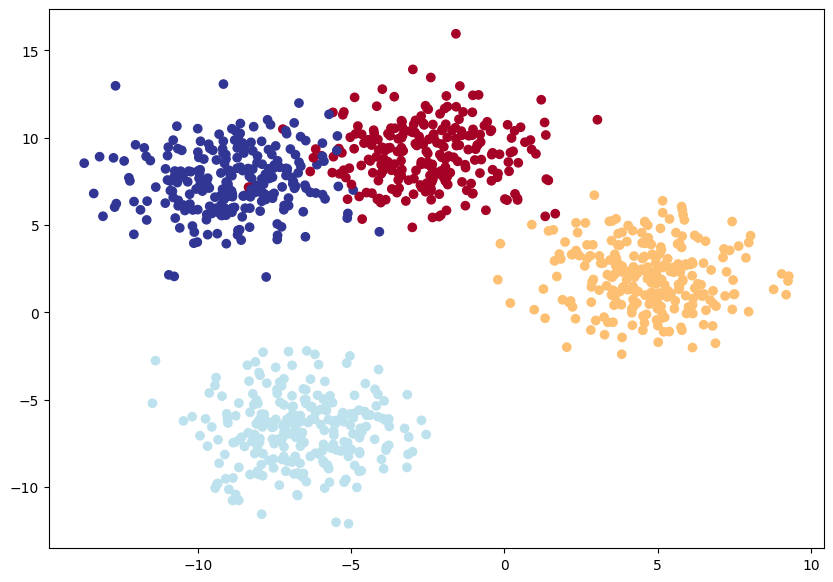

In [2]:
# set the hyper parameters for multiclass classification

NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42
#creating a multiclass data
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.8, # give the cluster a little shake up)
                            random_state=RANDOM_SEED)

# turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float) 
y_blob = torch.from_numpy(y_blob).type(torch.float) 

#spliting data into train and test
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
# plt.scatter(x_blob[:],y_blob,c=y_blob,cmap=plt.cm.RdYlBu)
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [4]:
#building a model
from torch import nn
class MultiClassClassification(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10,out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=10)

        self.layer4 = nn.Linear(in_features=10,out_features=4)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer4(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))))

In [3]:
# above cell is doing same so keep an eye on while executing the cell

class MulticlassClassificationv1(nn.Module):

    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()

        self.multiple_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )

    def forward(self,x):
        return self.multiple_layer_stack(x)

In [4]:
x_blob_train.shape,y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [5]:
torch.manual_seed(42)
model = MulticlassClassificationv1(input_features=2,
                                   output_features=4,
                                   hidden_units=10)
model.state_dict()

OrderedDict([('multiple_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('multiple_layer_stack.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('multiple_layer_stack.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3

In [6]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [9]:
# getting prediction probabilities for multiclass pyTorch model

# In order to evaluate and train and test out model, we need  to convert out model's output (logits) to prediction probabilities and then to prediction labels.
# Logits -> pred probs -> pred labels
with torch.inference_mode():
    y_logits = model(x_blob_train)


y_logits # logits (raw output)

y_compare = torch.argmax(y_logits,dim=1)



tensor([2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
        2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1,
        2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
        2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,

In [12]:
##convert out model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs

tensor([[0.2165, 0.2383, 0.4232, 0.1221],
        [0.1822, 0.3574, 0.3106, 0.1498],
        [0.2554, 0.2813, 0.2616, 0.2017],
        ...,
        [0.1813, 0.3634, 0.3191, 0.1363],
        [0.2560, 0.2764, 0.2621, 0.2055],
        [0.2122, 0.2837, 0.2931, 0.2110]])

In [13]:
# convert prediction probabilities into prediction labels 
y_pred_labels = torch.argmax(y_pred_probs,dim=1)
y_pred_labels

tensor([2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
        2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1,
        2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
        2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,

In [68]:
# above cell is doing same so keep an eye on while executing the cell
# convert prediction probabilities into prediction labels  ##brut-force method
y_pred_labels=torch.tensor([]) 
for i in range(len(y_pred_probs)):
    temp_tensor = y_pred_probs[i].argmax()
    y_pred_labels = torch.hstack((y_pred_labels,temp_tensor))

# t1 = torch.tensor([])
# t2 = torch.tensor([4])

# torch.hstack((t1,t2))

#### Creating a training loop for a multi-class PyTorch model

In [15]:
# training and testing

# fit the multi-class model to the data
torch.manual_seed(42)

#set the number of epochs
epochs = 100

#put the data on target device
x_blob_train,y_blob_train,x_blob_test,y_blob_test = x_blob_train.to(device),y_blob_train.to(device),x_blob_test.to(device),y_blob_test.to(device)

#loop through the data
for epoch in range(epochs):

    model.train()

    y_logits = model(x_blob_train)
    y_pred_probs = torch.softmax(y_logits,dim=1)
    y_pred_labels = torch.argmax(y_pred_probs,dim=1)

    loss_train = loss_fn(y_logits,y_blob_train)

    optimizer.zero_grad()

    loss_train.backward()

    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_test_preds = model(x_blob_test).squeeze()

        loss_test = loss_fun(y_test_preds,y_blob_test)

    if epoch % 10 == 0:
        print(f"{epoch} | training loss : {loss_train} | testing loss : {loss_test}")

RuntimeError: expected scalar type Long but found Float

In [14]:
torch.eq(y_compare,y_pred_labels)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr